In [1]:
import sqlite3
import matplotlib.pyplot as plt
import haversine as hs
import pandas as pd
import numpy as np
from math import sqrt, pow, log10
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import splines
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def f(x):
    t_flat, t_flong, a_flat, a_flong = x[0], x[1], x[2], x[3]
    return sqrt(pow(12.36,2) + pow(hs.haversine((t_flat, t_flong), (a_flat, a_flong), unit=hs.Unit.METERS),2))

def g(df):
    df['distance'] = df.iloc[:, 2:6].apply(f, axis=1)
    return df.drop(columns=['T_FLAT', 'T_FLONG', 'A_FLAT', 'A_FLONG'])

conn = sqlite3.connect("C:\\School\\rssi_ranging\\data_analysis\\rssi_1.db")
rssi_1_exp4 = g(pd.read_sql("SELECT * from exp4", conn))
rssi_1_exp5 = g(pd.read_sql("SELECT * FROM exp5", conn))
rssi_1_exp6 = g(pd.read_sql("SELECT * FROM exp6", conn))


conn = sqlite3.connect("C:\\School\\rssi_ranging\\data_analysis\\rssi_2.db")
rssi_2_exp4 = g(pd.read_sql("SELECT * from exp4", conn))
rssi_2_exp6 = g(pd.read_sql("SELECT * FROM exp6", conn))


conn = sqlite3.connect("C:\\School\\rssi_ranging\\data_analysis\\rssi_3.db")
rssi_3_exp4 = g(pd.read_sql("SELECT * from exp4", conn))
rssi_3_exp6 = g(pd.read_sql("SELECT * FROM exp6", conn))

conn = sqlite3.connect("C:\\School\\rssi_ranging\\data_analysis\\other_rssi.db")
rssi_1_exp3 = pd.read_sql("SELECT * from exp3", conn)
rssi_1_exp3['distance'] = rssi_1_exp3.iloc[:, 1]
rssi_1_exp3 = rssi_1_exp3.drop(columns=['FLAT', 'FLONG', 'Dist', 'ID'])


# df = pd.concat([
# #     rssi_1_exp4,
# #     rssi_1_exp5,
# #     rssi_1_exp6,
# #     rssi_2_exp4,
# #     rssi_2_exp6,
# #     rssi_3_exp4,
#     rssi_3_exp6
# ]).sort_values(by=['distance'], ignore_index=True).groupby('distance')['RSSI'].mean()
# plt.title("RSSI-to-distance model")
# plt.ylabel("RSSI (dBm)")
# plt.xlabel("Distance (m)")
# df.plot(style=".")
# # plt.semilogx()

--- Parameters ---
n: 1.9937724930236063
C: -69.21987423869518
--- MSRE ---
0.04266644115258772
--- Plots ---


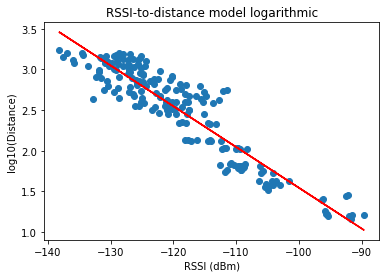

predict


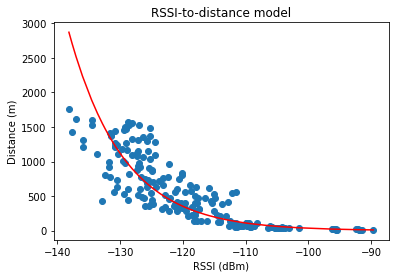

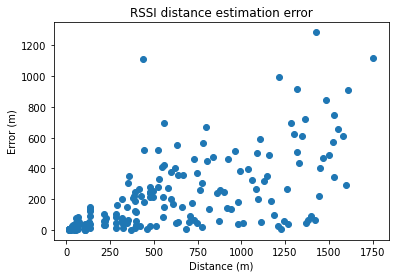

In [2]:
# Model

# Data
df = pd.concat([
    rssi_1_exp4,
    rssi_1_exp5,
    rssi_1_exp6,
#     rssi_2_exp4,
#     rssi_2_exp6,
    rssi_3_exp4,
    rssi_3_exp6]).sort_values(by=['distance'], ignore_index=True)
df2 = df.groupby('distance')['RSSI'].mean()

# Reformat data
d, rssi = df2.index.tolist(), df2.values.tolist()
X = df2.values.reshape(-1, 1)
Y = (np.log10(df2.index.to_series().values)).reshape(-1, 1)

# Train model
linear_regressor = LinearRegression()  # create object for the class
reg = linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
b = reg.coef_[0][0]
a = reg.intercept_[0]
n = -1 / (10*b)
C = 10 * n * a
print("--- Parameters ---")
print("n: " + str(n))
print("C: " + str(C))
print("--- MSRE ---")
print(mean_squared_error(Y, Y_pred))
print("--- Plots ---")
# Plot logarithmic
plt.title("RSSI-to-distance model logarithmic")
plt.xlabel("RSSI (dBm)")
plt.ylabel("log10(Distance)")
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()
print("predict")

# Plot base
plt.title("RSSI-to-distance model")
plt.xlabel("RSSI (dBm)")
plt.ylabel("Distance (m)")

X2 = df2.values
Y2 = 10 ** ((C - X2) / (10*n))
zipped = list(zip(*sorted(zip(X2, Y2), key=lambda x: x[1])))
X3, Y3 = zipped[0], zipped[1]
plt.plot(X3, Y3, color='red')
plt.scatter(X2, d)
plt.show()


plt.title("RSSI distance estimation error")
plt.xlabel("Distance (m)")
plt.ylabel("Error (m)")

X = df2.values.reshape(-1, 1)
Y = (df2.index.to_series().values).reshape(-1, 1)
plt.scatter(Y, np.abs(Y - (10 ** ((C - X) / (10*n)))))
plt.show()

In [3]:
path_loss = (lambda C, n : lambda RSSI: 10 ** ((C - RSSI) / (10*n)))(C,n)


def trilateration(anchors, rssi_to_distance):
    r1 = rssi_to_distance(anchors[0]['rssi'])
    r2 = rssi_to_distance(anchors[1]['rssi'])
    r3 = rssi_to_distance(anchors[2]['rssi'])
    x1, y1 = anchors[0]['coord'][0], anchors[0]['coord'][1]
    x2, y2 = anchors[1]['coord'][0], anchors[1]['coord'][1]
    x3, y3 = anchors[2]['coord'][0], anchors[2]['coord'][1]
    
    A = 2*x2 - 2*x1
    B = 2*y2 - 2*y1
    C = r1**2 - r2**2 - x1**2 + x2**2 - y1**2 + y2**2
    D = 2*x3 - 2*x2
    E = 2*y3 - 2*y2
    F = r2**2 - r3**2 - x2**2 + x3**2 - y2**2 + y3**2
    x = (C*E - F*B) / (E*A - B*D)
    y = (C*D - A*F) / (B*D - A*E)
    
    return x,y

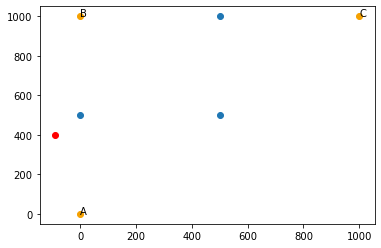

In [8]:
rssi1, rssi2, rssi3 = -122, -125, -131

r1, r2, r3 = 500, 500, 1130

RSSI = (lambda C, n : lambda x : -10*n*log10(x) + C)(C, n)
a1_latlong = (50.96227, 5.14446)
a2_latlong = (50.954, 5.15005)
a3_latlong = (50.959, 5.13124)

a1, a2, a3 = {'coord': (0,0), 'rssi': rssi1}, {'coord': (0,1000), 'rssi': rssi2}, {'coord': (1000,1000), 'rssi': rssi3}

anchors = [a1, a2, a3]

# Data
x1, y1 = anchors[0]['coord'][0], anchors[0]['coord'][1]
x2, y2 = anchors[1]['coord'][0], anchors[1]['coord'][1]
x3, y3 = anchors[2]['coord'][0], anchors[2]['coord'][1]
x4, y4 = trilateration(anchors, path_loss)
p1x, p1y = (0, 500)
p2x, p2y = (500, 500)
p3x, p3y = (500, 1000)
pxs = [p1x,p2x,p3x]
pys = [p1y,p2y,p3y]

# Plot
fig, ax = plt.subplots()
x = [anchor['coord'][0] for anchor in anchors]
y = [anchor['coord'][1] for anchor in anchors]
anchor_labels = ['A', 'B', 'C']
ax.scatter(x, y, color='#F5A101')
for i, txt in enumerate(anchor_labels):
    ax.annotate(txt, (x[i], y[i]))
    
ax.scatter(*trilateration(anchors, path_loss), color='red')
ax.scatter([p1x,p2x,p3x],[p1y,p2y,p3y], color='#1f77b4')
plt.show()